In [35]:
import os
from pathlib import Path
from typing import cast

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
from IPython.display import display

import modfs.utils.plotting as plot
from modfs.data.result_load import add_derived_columns, load_results

ROOT_PATH = Path("../../../").resolve()
FIGS_DIR = ROOT_PATH / "data/figs/paper/modular-scheduling"
FIGS_DIR.mkdir(exist_ok=True, parents=True)

results_path = ROOT_PATH / "data/run"

df_original = load_results(results_path)

# The C++ code has a bug that doesn't count the last iteration as such. We fix this here.
df_original["iterations"] += 1

# Set names of simple schedulers
df_original.loc[
    (df_original["modular_algorithm"] == "cocktail") & (df_original["algorithm"] == "simple"),
    "modular_algorithm",
] = "MAS-CS"
df_original.loc[
    (df_original["modular_algorithm"] == "broadcast") & (df_original["algorithm"] == "simple"),
    "modular_algorithm",
] = "MAS-BS"

# Fix for wrong error message on constraint
df_original.loc[
    (df_original["modular_algorithm"] == "Constraint")
    & (df_original["error"] == "")
    & (df_original["solved"] == False),
    "error",
] = "time-out"

# Import heterogeneous bookletA and bookletAB as computational-orig to be able to compare
# with computational that has a run time of 1 hour instead of 10 minutes. We add os.sep at the end
# to avoid matching with bookletABUniform or bookletAUniform.
generic_names = [f"generic/mixed/duplex/booklet{a}" for a in ["A", "AB"]]
vals = tuple(str(results_path / p) + os.sep for p in generic_names)
df_tmp = df_original[df_original["run_file_path"].str.startswith(vals)].copy()
df_tmp["run_file_path"] = df_tmp["run_file_path"].str.replace(
    str(Path("generic/mixed/duplex")), "computational"
)
df_tmp["original_path"] = df_tmp["original_path"].str.replace(
    "generic/mixed/duplex", "computational"
)

df_original = pd.concat([df_original, df_tmp], ignore_index=True)

df_original_p = add_derived_columns(
    df_original,
    groups={
        "homogeneous": {"generic/printer_cases"},
        "heterogeneous": {"generic/mixed"},
        "computational": {"computational"},
    },
    gen_subpath="data/gen",
    group_source="run_file_path",
    run_subpath=results_path,
    exclude_paths=[],
)

selector = df_original_p["original_path"].str.startswith(("printer_cases", "mixed"))
df_original_p.loc[selector, "original_path"] = (
    "generic/" + df_original_p.loc[selector, "original_path"]
)

df_all = df_original_p.query("group.isin(['homogeneous', 'heterogeneous', 'computational'])")
df_all.replace(
    {
        "modular_algorithm": {"cocktail": "MAS-C", "constraint": "MON", "broadcast": "MAS-B"},
        "error": {"": "none"},
    },
    inplace=True,
)

df_generic = df_all.query("group.isin(['homogeneous', 'heterogeneous'])")
df_computational = df_all.query(
    "group == 'computational' & ~(modular_algorithm == 'MON' & time_limit == 600)"
)

del df_original, df_original_p, df_tmp

figs = {}

Looking for files to load


Loading info files:   0%|          | 0/90 [00:00<?, ?it/s]

All files loaded!


In [36]:
colors = {
    "notimeout": "tab:blue",
    "MON": "tab:green",
    "MAS": "tab:olive",
    "MAS-C": "tab:olive",
    "MAS-B": "tab:orange",
    "MAS-BS": "tab:purple",
    "MAS-CS": "tab:cyan",
    600: "tab:purple",
    3600: "tab:cyan",
}
markers = {"MON": ".", "MAS": "*", "MAS-C": "*", "MAS-B": "o"}
hatches = {"MON": "", "MAS-C": "////", "MAS-B": r"\\\\", 600: "////", 3600: r"\\\\"}

number_colors = {
    2: "tab:blue",
    3: "tab:orange",
    4: "tab:green",
    5: "tab:red",
    6: "tab:purple",
    7: "tab:brown",
    8: "tab:pink",
    9: "tab:gray",
    10: "tab:olive",
}

number_markers = {
    2: ".",
    3: "1",
    4: "2",
    5: "3",
    6: "4",
    7: "*",
    8: "+",
    9: "x",
    10: 8,
}

group             heterogeneous            homogeneous           
modular_algorithm         MAS-B      MAS-C       MAS-B      MAS-C
error                                                            
Solved                85.578704  89.166667   85.347222  90.833333
Local                  5.069444   7.013889    4.606481   5.254630
Time                   9.351852   3.819444   10.046296   3.912037

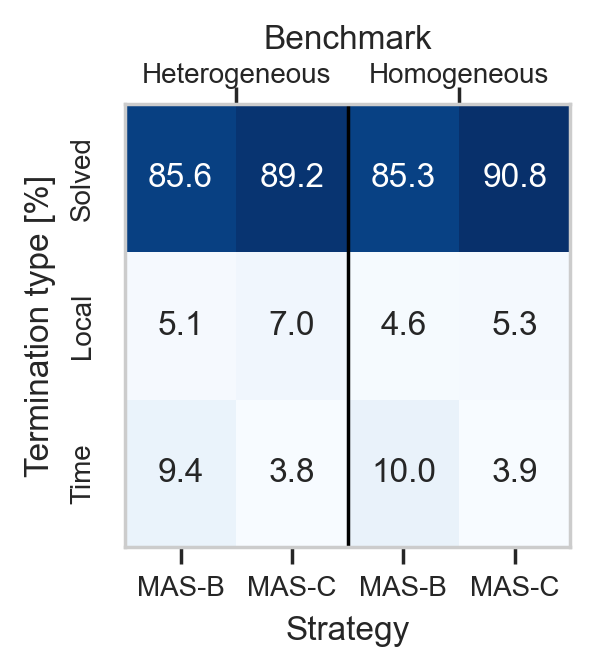

modular_algorithm      MAS-B                 MAS-C           
time_limit              600        3600       600        3600
error                                                        
Solved             88.240741  95.370370  95.185185  95.462963
Local               3.611111   3.981481   4.537037   4.537037
Time                8.148148   0.648148   0.277778   0.000000

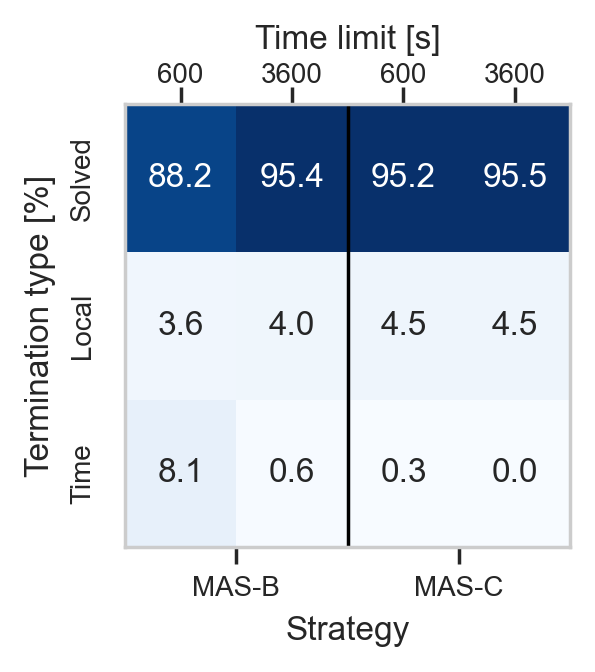

In [37]:
table = df_all.pivot_table(
    index=["group", "modular_algorithm", "algorithm", "time_limit"],
    columns="error",
    aggfunc="size",
    fill_value=0,
)
important_cols = table.columns.copy()
table["total"] = table.sum(axis=1)

table2 = table.drop(columns=["total"])
table2[important_cols] = table2[important_cols].div(table["total"], axis=0) * 100

table = pd.concat({"sum": table, "%": table2}, axis=1)
s = table.style
s.format("{:.1f}", ["%"])
s.set_table_styles([{"selector": "th", "props": "text-align: center;"}])
display(s)

# Take only heterogeneous and homogeneous
table_generic = cast(
    pd.DataFrame,
    table.query(
        "group in ['homogeneous', 'heterogeneous'] & modular_algorithm != 'MON' & time_limit == 600 "
        "& algorithm != 'simple'"
    )["%"],
)
# Drop the last two index levels
table_generic.index = table_generic.index.droplevel([2, 3])
table_generic = table_generic.reindex(columns=["none", "local-scheduler", "time-out"])
rename_dict = {"local-scheduler": "Local", "none": "Solved", "time-out": "Time"}
table_generic = table_generic.rename(columns=rename_dict).T

display(table_generic)

plt.figure(figsize=(2.3, 2.3), dpi=250)
sns.set_theme(context="paper", style="whitegrid")
g = sns.heatmap(
    table_generic,
    annot=True,
    fmt=".1f",
    cmap="Blues",
    cbar=False,
    xticklabels=["MAS-B", "MAS-C"] * 2,
)
plt.ylabel("Termination type [%]")
plt.xlabel("Strategy")
g.tick_params(axis="both", labelsize="small")
g.tick_params(axis="x", rotation=0)

ax2 = g.twiny()
ax2.set_xticks(
    [1, 3],
    ["Heterogeneous", "Homogeneous"],
    # rotation="vertical",
    rotation_mode="default",
    fontsize="small",
    verticalalignment="center",
)
ax2.set_xlim(0, 4)
ax2.set_xlabel("Benchmark")
ax2.vlines([2], *ax2.get_ylim(), color="black", linewidth=1)
ax2.grid(False)

plt.savefig(FIGS_DIR / "termination_type_generic.pdf", bbox_inches="tight", pad_inches=0)

plt.show()

table_comp = cast(
    pd.DataFrame,
    table.query("group == 'computational' & modular_algorithm != 'MON' & algorithm != 'simple'")[
        "%"
    ],
)

table_comp.index = table_comp.index.droplevel([0, 2])
table_comp = table_comp.reindex(columns=["none", "local-scheduler", "time-out"])
table_comp = table_comp.rename(columns=rename_dict).T
display(table_comp)

plt.figure(figsize=(2.3, 2.3), dpi=250)
sns.set_theme(context="paper", style="whitegrid")
g = sns.heatmap(
    table_comp,
    annot=True,
    fmt=".1f",
    cmap="Blues",
    cbar=False,
    xticklabels=[600, 3600] * 2,
)
plt.ylabel("Termination type [%]")
plt.xlabel("Strategy")
g.tick_params(axis="both", labelsize="small")
g.set_xticks([1, 3], ["MAS-B", "MAS-C"], rotation=0)

ax2 = g.twiny()
ax2.set_xticks(
    [.5, 1.5, 2.5, 3.5],
    [600, 3600]*2,
    fontsize="small",
    verticalalignment="center",
)
ax2.set_xlim(0, 4)
ax2.set_xlabel("Time limit [s]")
ax2.vlines([2], *ax2.get_ylim(), color="black", linewidth=1)
ax2.grid(False)

plt.savefig(FIGS_DIR / "termination_type_computational.pdf", bbox_inches="tight", pad_inches=0)
plt.show()



makespan
group         modular_algorithm          
heterogeneous MAS-B              1.238687
              MAS-BS             4.143947
              MAS-C              1.181021
              MAS-CS             4.143947
homogeneous   MAS-B              1.151220
              MAS-BS             4.169583
              MAS-C              1.117823
              MAS-CS             4.169583

,makespan
modular_algorithm,
MAS-B,1.195025
MAS-BS,4.156780
MAS-C,1.149096
MAS-CS,4.156780


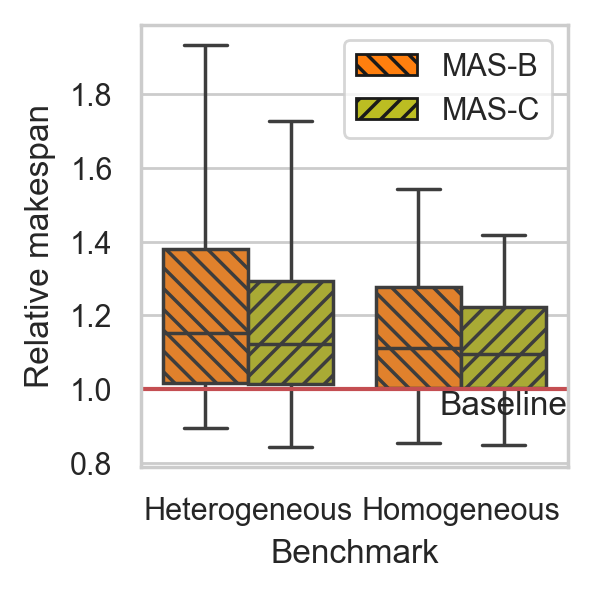

In [39]:
# Draw boxplot comparing the makespan
df_other, df_baseline = plot.baseline_extract(df_all, "MON", "modular_algorithm")


df_compared = plot.baseline_compare(df_generic, "MON", "makespan")
display(df_compared.groupby(["group", "modular_algorithm"])["makespan"].mean().to_frame())
display(df_compared.groupby(["modular_algorithm"])["makespan"].mean().to_frame())

plt.figure(figsize=(2.2, 2.3), dpi=250)
sns.set_theme(context="paper", style="whitegrid")
g = sns.boxplot(
    data=df_compared,
    x="group",
    y="makespan",
    hue="modular_algorithm",
    hue_order=["MAS-B", "MAS-C"],
    palette=colors,
    legend=False,
    whis=(5, 95),
    showfliers=False,
)

hatches_lst = [hatches["MAS-B"]] * 2 + [hatches["MAS-C"]] * 2

for patch, hatch in zip(g.patches, hatches_lst):
    patch.set_hatch(hatch)

plt.axhline(y=1, color="r")
plt.text(.9, 0.93, "Baseline")

from matplotlib.patches import Patch
plt.legend(
    handles=[
        Patch(facecolor=colors["MAS-B"], edgecolor="k", hatch=hatches["MAS-B"], label="MAS-B"),
        Patch(facecolor=colors["MAS-C"], edgecolor="k", hatch=hatches["MAS-C"], label="MAS-C"),
    ],
    loc="upper right",
)

plt.ylabel("Relative makespan")
plt.xlabel("Benchmark")
plt.xticks([0, 1], ["Heterogeneous", "Homogeneous"])

plt.savefig(FIGS_DIR / "makespan_all.pdf", bbox_inches="tight", pad_inches=0)
plt.show()

solved
group         modular_algorithm          
heterogeneous MAS-B              0.855787
              MAS-BS             1.000000
              MAS-C              0.891667
              MAS-CS             1.000000
              MON                0.985648
homogeneous   MAS-B              0.853472
              MAS-BS             1.000000
              MAS-C              0.908333
              MAS-CS             1.000000
              MON                0.987963

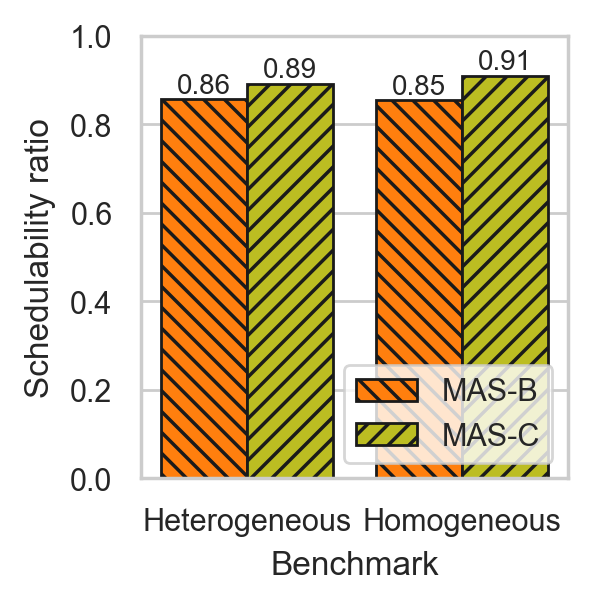

In [40]:
# Draw bar plot comparing number of finished solutions
df_completed = df_generic.groupby(["group", "modular_algorithm"])["solved"].mean()
display(df_completed.to_frame())

plt.figure(figsize=(2.2, 2.3), dpi=250)
sns.set_theme(context="paper", style="whitegrid")

xposition = [0, 0.4, 1, 1.4]
yposition = [
    df_completed["heterogeneous", "MAS-B"],
    df_completed["heterogeneous", "MAS-C"],
    df_completed["homogeneous", "MAS-B"],
    df_completed["homogeneous", "MAS-C"],
]

plt.bar(
    xposition,
    yposition,
    width=0.4,
    edgecolor="k",
    color=[colors["MAS-B"], colors["MAS-C"]] * 2,
    hatch=[hatches["MAS-B"], hatches["MAS-C"]] * 2,
)
from matplotlib.patches import Patch

for x, y in zip(xposition, yposition):
    plt.text(x, y + 0.015, f"{y:.2f}", fontsize="small", horizontalalignment="center")

plt.legend(
    handles=[
        Patch(facecolor=colors["MAS-B"], edgecolor="k", hatch="\\\\\\\\", label="MAS-B"),
        Patch(facecolor=colors["MAS-C"], edgecolor="k", hatch="////", label="MAS-C"),
    ],
    loc="lower right",
)
plt.xticks([0.2, 1.2], ["Heterogeneous", "Homogeneous"])
plt.ylabel("Schedulability ratio")
plt.xlabel("Benchmark")
plt.ylim(0, 1)
plt.grid(axis="x")
plt.savefig(FIGS_DIR / "schedulability_ratio_all.pdf", bbox_inches="tight", pad_inches=0)
plt.show()

total_time
group         modular_algorithm            
heterogeneous MAS-B              108.917905
              MAS-BS               4.426313
              MAS-C               61.647653
              MAS-CS               1.485167
              MON                495.117697
homogeneous   MAS-B              112.132909
              MAS-BS               4.561173
              MAS-C               62.333186
              MAS-CS               1.480986
              MON                493.733066

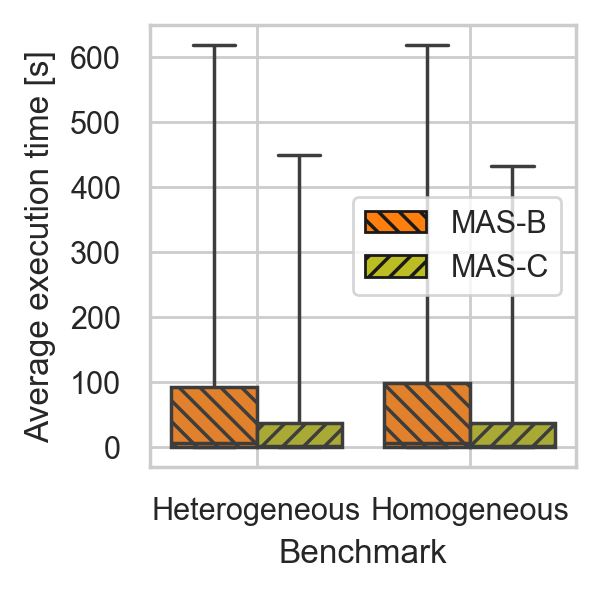

In [41]:

# Draw boxplot comparing the total execution time
df_time = df_generic.copy()
df_time["total_time"] /= 1000

display(df_time.groupby(["group", "modular_algorithm"])["total_time"].mean().to_frame())

plt.figure(figsize=(2.2, 2.3), dpi=250)
sns.set_theme(context="paper", style="whitegrid")
g = sns.boxplot(
    data=df_time,
    x="group",
    y="total_time",
    hue="modular_algorithm",
    hue_order=["MAS-B", "MAS-C"],
    palette=colors,
    legend=False,
    whis=(5, 95),
    showfliers=False,
)

hatches_lst = [hatches["MAS-B"]] * 2 + [hatches["MAS-C"]] * 2

for patch, hatch in zip(g.patches, hatches_lst):
    patch.set_hatch(hatch)

from matplotlib.patches import Patch
plt.legend(
    handles=[
        Patch(facecolor=colors["MAS-B"], edgecolor="k", hatch=hatches["MAS-B"], label="MAS-B"),
        Patch(facecolor=colors["MAS-C"], edgecolor="k", hatch=hatches["MAS-C"], label="MAS-C"),
    ],
    loc="right",
)

plt.xticks([0, 1], ["Heterogeneous", "Homogeneous"])
plt.ylabel("Average execution time [s]")
plt.xlabel("Benchmark")
plt.grid(axis="x")
plt.savefig(FIGS_DIR / "execution_time_all.pdf", bbox_inches="tight", pad_inches=0)
plt.show()

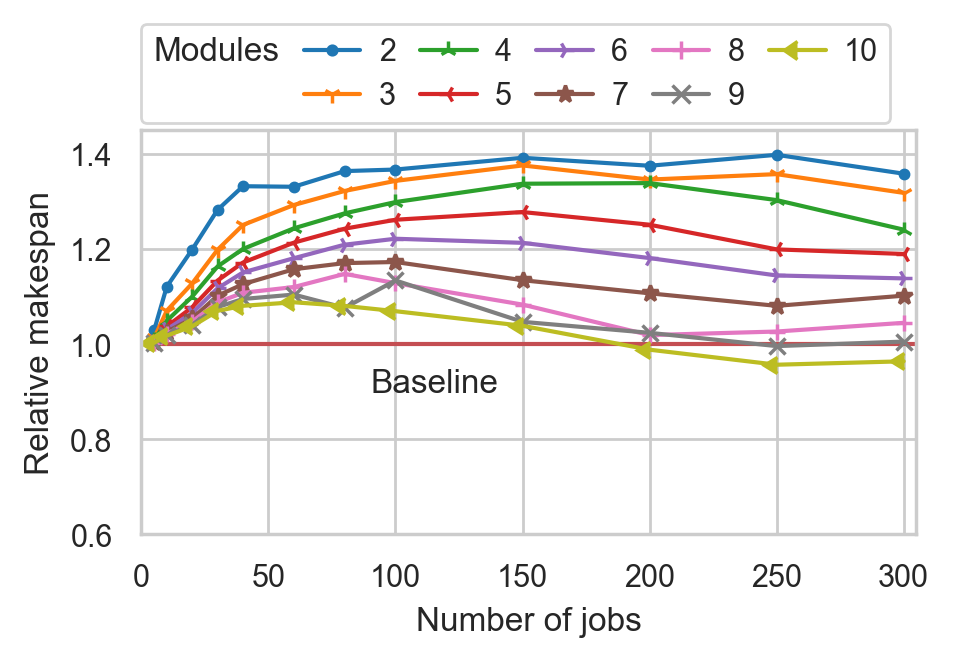

In [42]:
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle

df_compared = plot.baseline_compare(df_generic, "MON", "makespan")

number_colors = {
    2: "tab:blue",
    3: "tab:orange",
    4: "tab:green",
    5: "tab:red",
    6: "tab:purple",
    7: "tab:brown",
    8: "tab:pink",
    9: "tab:gray",
    10: "tab:olive",
}

number_markers = {
    2: ".",
    3: "1",
    4: "2",
    5: "3",
    6: "4",
    7: "*",
    8: "+",
    9: "x",
    10: 8,
}

plt.figure(figsize=(4, 2.1), dpi=250)
sns.set(context="paper", style="whitegrid")

plt.axhline(1, color="r")
plt.text(90, .9, "Baseline")

for group, df in df_compared[df_compared["modular_algorithm"] == "MAS-C"].groupby("modules"):
    group = cast(int, group)
    # if group % 2 != 0:
    #     continue
    
    df_tmp = df.groupby("jobs", as_index=False)["makespan"].mean()
    plt.plot(
        df_tmp["jobs"],
        df_tmp["makespan"],
        color=number_colors[group],
        marker=number_markers[group],
    ),

l = plt.legend(
    [
        Line2D(
            [],
            [],
            color=number_colors[i],
            marker=number_markers[i],
            markersize=5.0,
        )
        for i in range(2, 11, 1)
    ],
    [f"{i}" for i in range(2, 11, 1)],
    loc="upper left",
    bbox_to_anchor=(-0.02, 1.3),
    title="Modules",
    ncol=5,
    handlelength=1.85,
    columnspacing=.8,
    handletextpad=.6,
)

# From https://stackoverflow.com/a/53329898/4005637
c = l.get_children()[0]
title = c.get_children()[0]
hpack = c.get_children()[1]
c._children = [hpack]
hpack._children = [title] + hpack.get_children()

plt.xlim(0, 305)
plt.ylim(0.6, 1.45)
plt.ylabel("Relative makespan")
plt.xlabel("Number of jobs")
plt.savefig(FIGS_DIR / "makespan_by_jobs_modules.pdf", bbox_inches="tight", pad_inches=0)
plt.show()


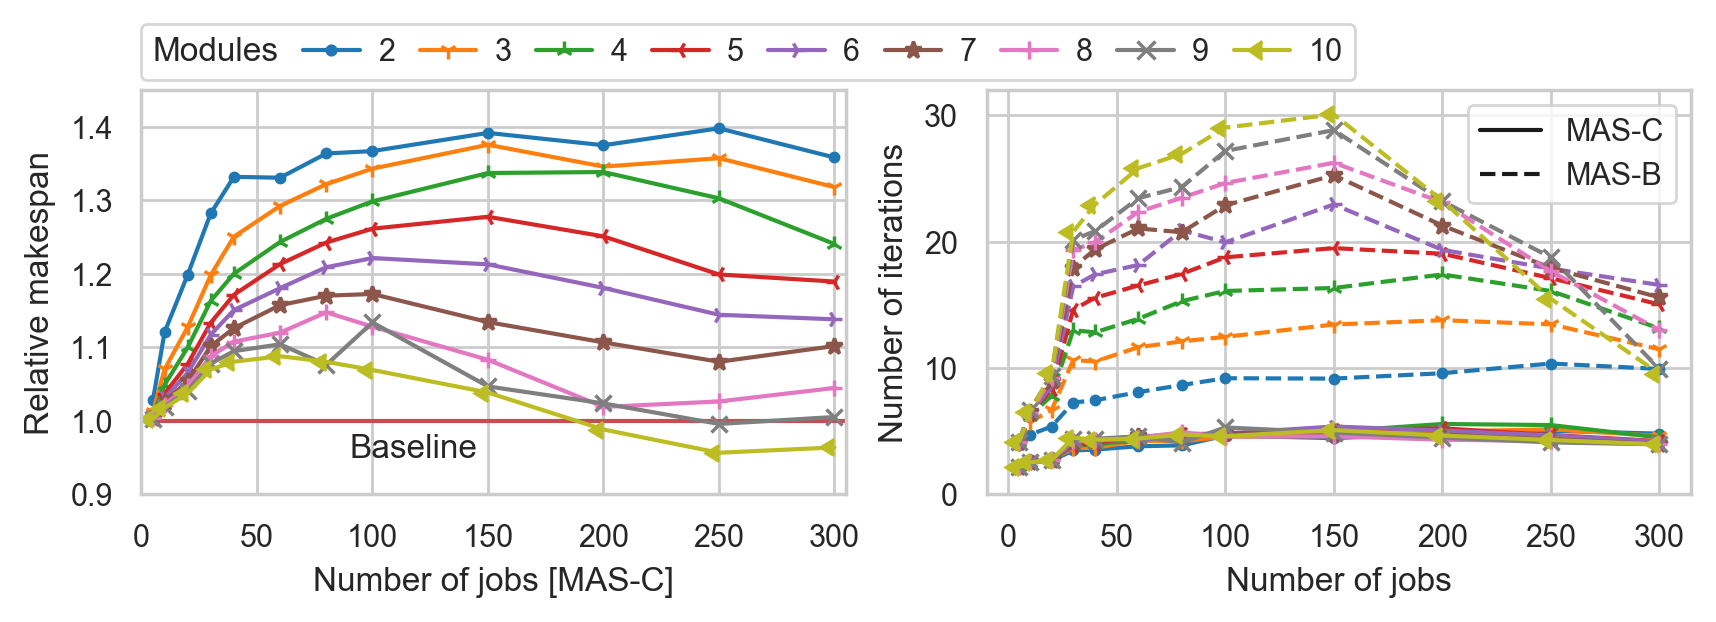

In [43]:
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 2.1), dpi=250)
sns.set_theme(context="paper", style="whitegrid")

ax1.axhline(1, color="r")
ax1.text(90, .95, "Baseline")

df_compared = plot.baseline_compare(df_generic, "MON", "makespan")
for group, df in df_compared[df_compared["modular_algorithm"] == "MAS-C"].groupby("modules"):
    group = cast(int, group)
    # if group % 2 != 0:
    #     continue
    
    df_tmp = df.groupby("jobs", as_index=False)["makespan"].mean()
    ax1.plot(
        df_tmp["jobs"],
        df_tmp["makespan"],
        color=number_colors[group],
        marker=number_markers[group],
    ),

l = ax1.legend(
    [
        Line2D(
            [],
            [],
            color=number_colors[i],
            marker=number_markers[i],
            markersize=5.0,
        )
        for i in range(2, 11, 1)
    ],
    [f"{i}" for i in range(2, 11, 1)],
    loc="upper left",
    bbox_to_anchor=(-0.023, 1.2),
    title="Modules",
    ncol=9,
    handlelength=1.85,
    columnspacing=.8,
    handletextpad=.6,
)


# From https://stackoverflow.com/a/53329898/4005637
c = l.get_children()[0]
title = c.get_children()[0]
hpack = c.get_children()[1]
c._children = [hpack]
hpack._children = [title] + hpack.get_children()

ax1.set_xlim(0, 305)
ax1.set_ylim(0.9, 1.45)
ax1.set_ylabel("Relative makespan")
ax1.set_xlabel("Number of jobs [MAS-C]")


for group, df in df_generic.query('solved').groupby("modules"):
    group = cast(int, group)
    df_tmp = df.groupby(["modular_algorithm", "jobs"])["iterations"].mean()
    ax2.plot(
        df_tmp.loc["MAS-C"].index,
        df_tmp.loc["MAS-C"],
        color=number_colors[group],
        marker=number_markers[group],
    )
    ax2.plot(
        df_tmp.loc["MAS-B"].index,
        df_tmp.loc["MAS-B"],
        color=number_colors[group],
        marker=number_markers[group],
        linestyle="--",
    )

ax2.legend(
    [Line2D([], [], color="k"), Line2D([], [], color="k", linestyle="--")],
    ["MAS-C", "MAS-B"],
)

ax2.set_ylabel("Number of iterations")
ax2.set_xlabel("Number of jobs")
ax2.set_ylim(0, 32)

plt.savefig(FIGS_DIR / "makespan_by_jobs_modules_and_number_of_iterations.pdf", bbox_inches="tight", pad_inches=0)
plt.show()


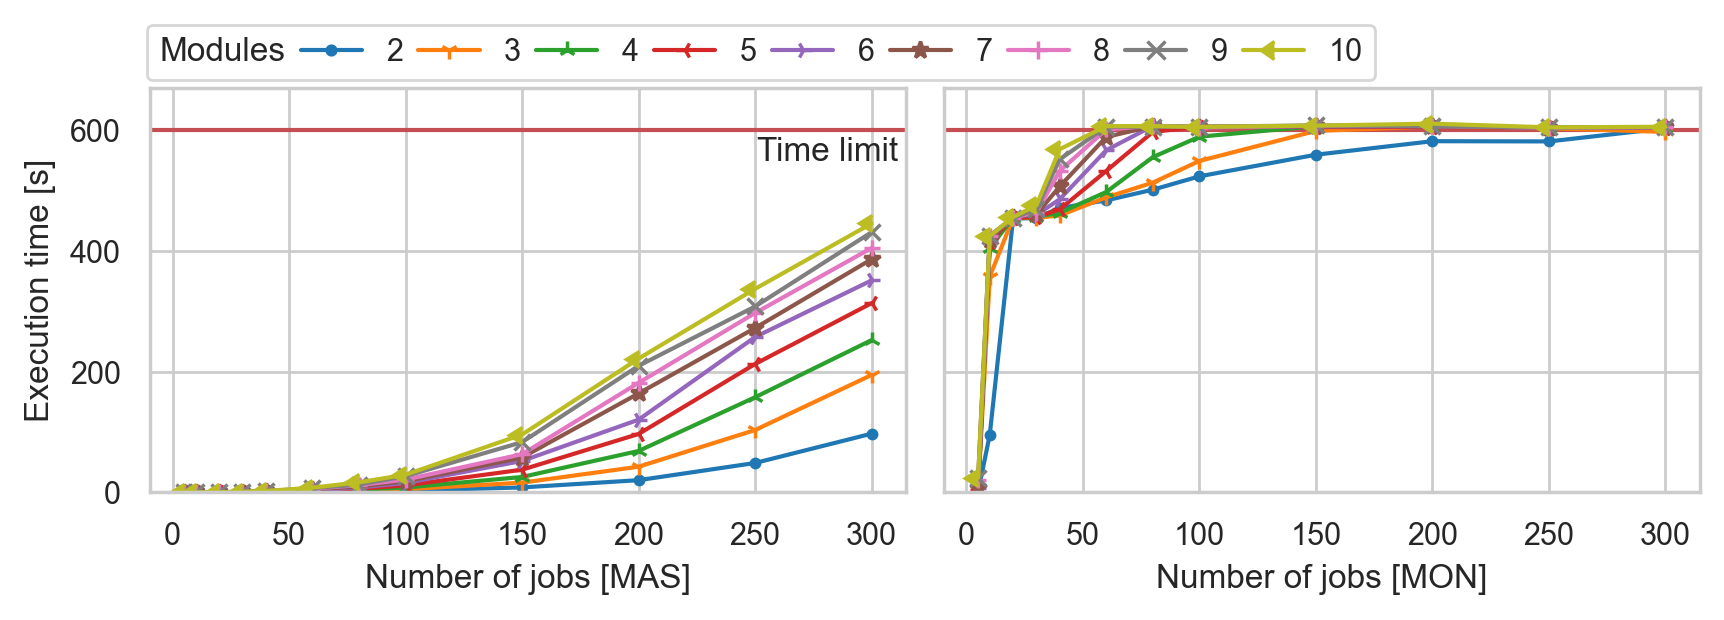

In [44]:
from matplotlib.text import Text

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 2.1), dpi=250, sharey=True)
plt.subplots_adjust(wspace=0.05)
ax2.axhline(10 * 60, color="r")
ax1.axhline(10 * 60, color="r")
for group, df in df_generic.groupby("modules"):
    df_tmp = df.groupby(["jobs", "modular_algorithm"], as_index=False)["total_time"].mean()
    df_mod = df_tmp[df_tmp["modular_algorithm"] == "MAS-C"]
    group = cast(int, group)
    ax1.plot(
        df_mod["jobs"],
        df_mod["total_time"]/1000,
        color=number_colors[group],
        marker=number_markers[group],
    )
    df_mon = df_tmp[df_tmp["modular_algorithm"] == "MON"]
    ax2.plot(
        df_mon["jobs"],
        df_mon["total_time"]/1000,
        color=number_colors[group],
        marker=number_markers[group],
    )

ax2.text(-90, 10 * 60 - 50, "Time limit")
ax1.set_xlabel("Number of jobs [MAS]")
ax2.set_xlabel("Number of jobs [MON]")
ax1.set_ylabel("Execution time [s]")
plt.ylim(0, 670)
# plt.yscale("log")
l = fig.legend(
    # [ Line2D([], [], color='none') ] + [
    [
        Line2D([0], [0], color=number_colors[i], marker=number_markers[i], markersize=5.0)
        for i in range(2, 11)
    ],
    [f'{i}' for i in range(2, 11)],
    # ["Modules"] + [f'{i}' for i in range(2, 11)],
    loc='upper left',
    bbox_to_anchor=(0.116, 1.03),
    title="Modules",
    ncol=9,
    columnspacing=0.5,
)

# From https://stackoverflow.com/a/53329898/4005637
c = l.get_children()[0]
title = c.get_children()[0]
hpack = c.get_children()[1]
c._children = [hpack]
hpack._children = [title] + hpack.get_children()

# l.get_title().set_position((-630, -45))
plt.savefig(FIGS_DIR / "execution_time_by_jobs_modules.pdf", bbox_inches="tight", pad_inches=0)
plt.show()

from IPython.display import HTML
df_selected = df_generic.query("modular_algorithm != 'MON' & algorithm != 'simple'")
df_tmp = df_selected.groupby(["modular_algorithm", "modules", "jobs"])["total_time"].mean().to_frame()
df_tmp["total_time"] /= 1000
df_tmp = df_tmp.unstack("modules")
display(HTML(df_tmp.style.format("{:.1f}").to_html()))

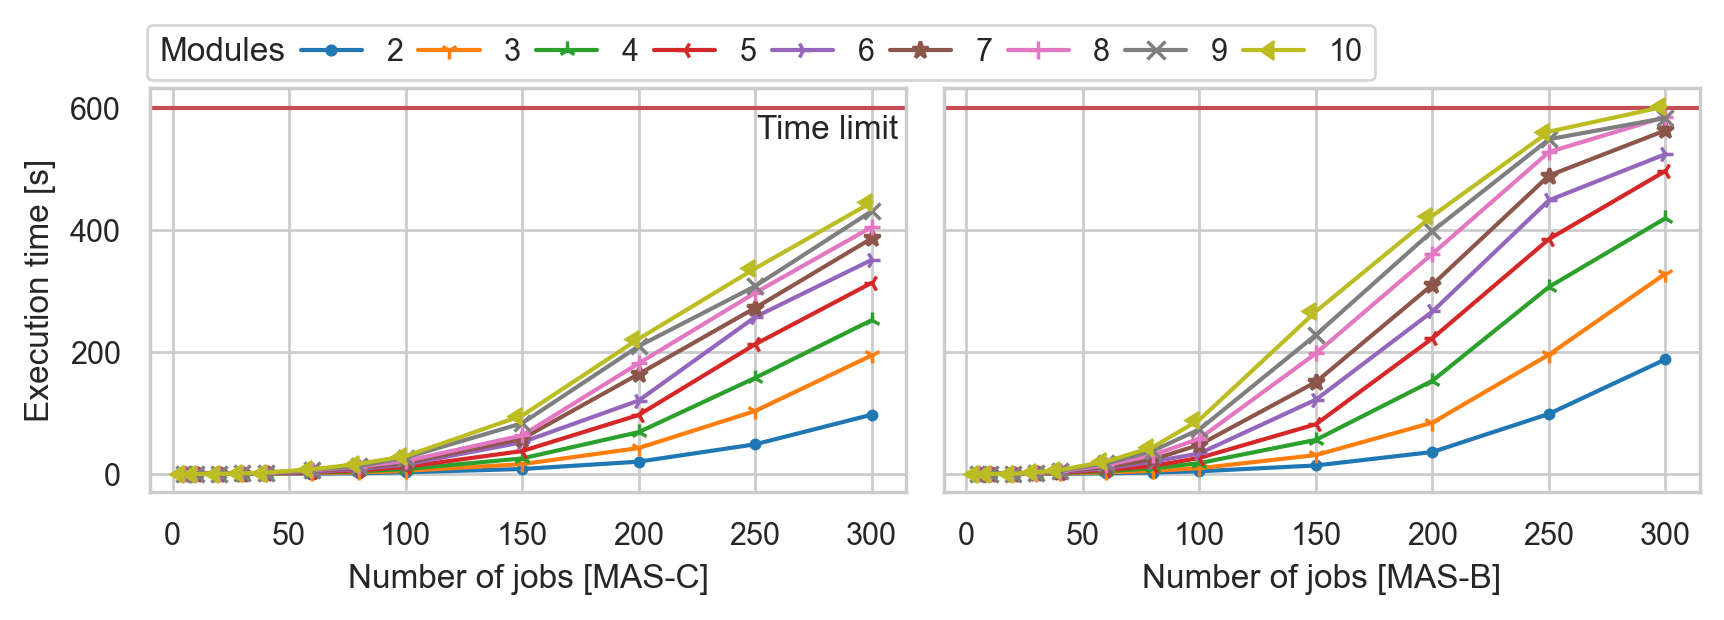

In [45]:
from matplotlib.text import Text

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 2.1), dpi=250, sharey=True)
plt.subplots_adjust(wspace=0.05)
ax2.axhline(10 * 60, color="r")
ax1.axhline(10 * 60, color="r")
for group, df in df_generic.groupby("modules"):
    df_tmp = df.groupby(["jobs", "modular_algorithm"], as_index=False)["total_time"].mean()
    df_mod = df_tmp[df_tmp["modular_algorithm"] == "MAS-C"]
    group = cast(int, group)
    ax1.plot(
        df_mod["jobs"],
        df_mod["total_time"]/1000,
        color=number_colors[group],
        marker=number_markers[group],
    )
    df_mon = df_tmp[df_tmp["modular_algorithm"] == "MAS-B"]
    ax2.plot(
        df_mon["jobs"],
        df_mon["total_time"]/1000,
        color=number_colors[group],
        marker=number_markers[group],
    )

ax2.text(-90, 10 * 60 - 50, "Time limit")
ax1.set_xlabel("Number of jobs [MAS-C]")
ax2.set_xlabel("Number of jobs [MAS-B]")
ax1.set_ylabel("Execution time [s]")
l = fig.legend(
    # [ Line2D([], [], color='none') ] + [
    [
        Line2D([0], [0], color=number_colors[i], marker=number_markers[i], markersize=5.0)
        for i in range(2, 11)
    ],
    [f'{i}' for i in range(2, 11)],
    # ["Modules"] + [f'{i}' for i in range(2, 11)],
    loc='upper left',
    bbox_to_anchor=(0.116, 1.03),
    title="Modules",
    ncol=9,
    columnspacing=0.5,
)

# From https://stackoverflow.com/a/53329898/4005637
c = l.get_children()[0]
title = c.get_children()[0]
hpack = c.get_children()[1]
c._children = [hpack]
hpack._children = [title] + hpack.get_children()

# l.get_title().set_position((-630, -45))
plt.savefig(FIGS_DIR / "execution_time_by_jobs_modules_c_b.pdf", bbox_inches="tight", pad_inches=0)
plt.show()


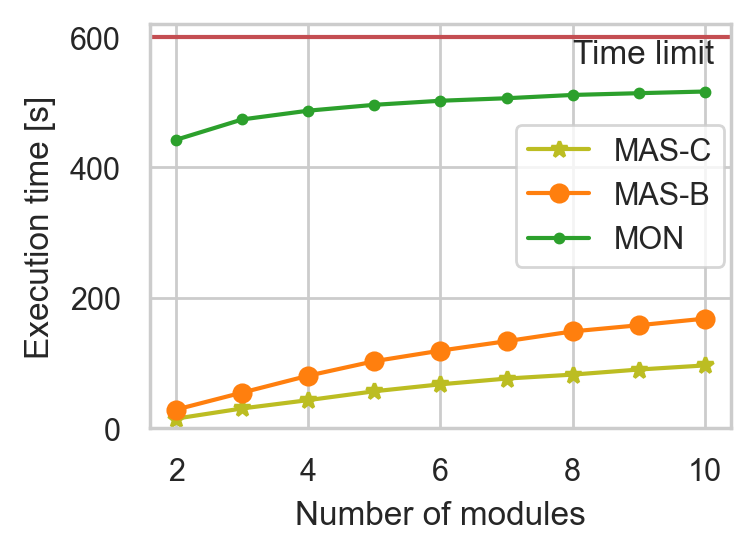

In [46]:
plt.figure(figsize=(3, 2.1), dpi=250)
plt.subplots_adjust(wspace=0.05)

df_tmp = df_generic.groupby(["modular_algorithm", "modules"])["total_time"].mean()
plt.plot(
    df_tmp.loc["MAS-C"].index,
    df_tmp.loc["MAS-C"]/1000,
    color=colors["MAS-C"],
    marker=markers["MAS-C"],
    label="MAS-C"
)
plt.plot(
    df_tmp.loc["MAS-B"].index,
    df_tmp.loc["MAS-B"]/1000,
    color=colors["MAS-B"],
    marker=markers["MAS-B"],
    label="MAS-B"
)
plt.plot(
    df_tmp.loc["MON"].index,
    df_tmp.loc["MON"]/1000,
    color=colors["MON"],
    marker=markers["MON"],
    label="MON",
)

plt.axhline(10 * 60, color="r")
plt.text(8, 10 * 60 - 40, "Time limit")
plt.xlabel("Number of modules")
plt.ylabel("Execution time [s]")
plt.ylim(0, 620)
plt.legend(loc=(0.63, 0.4))
plt.savefig(FIGS_DIR / "execution_time_by_modules.pdf", bbox_inches="tight", pad_inches=0)
plt.show()

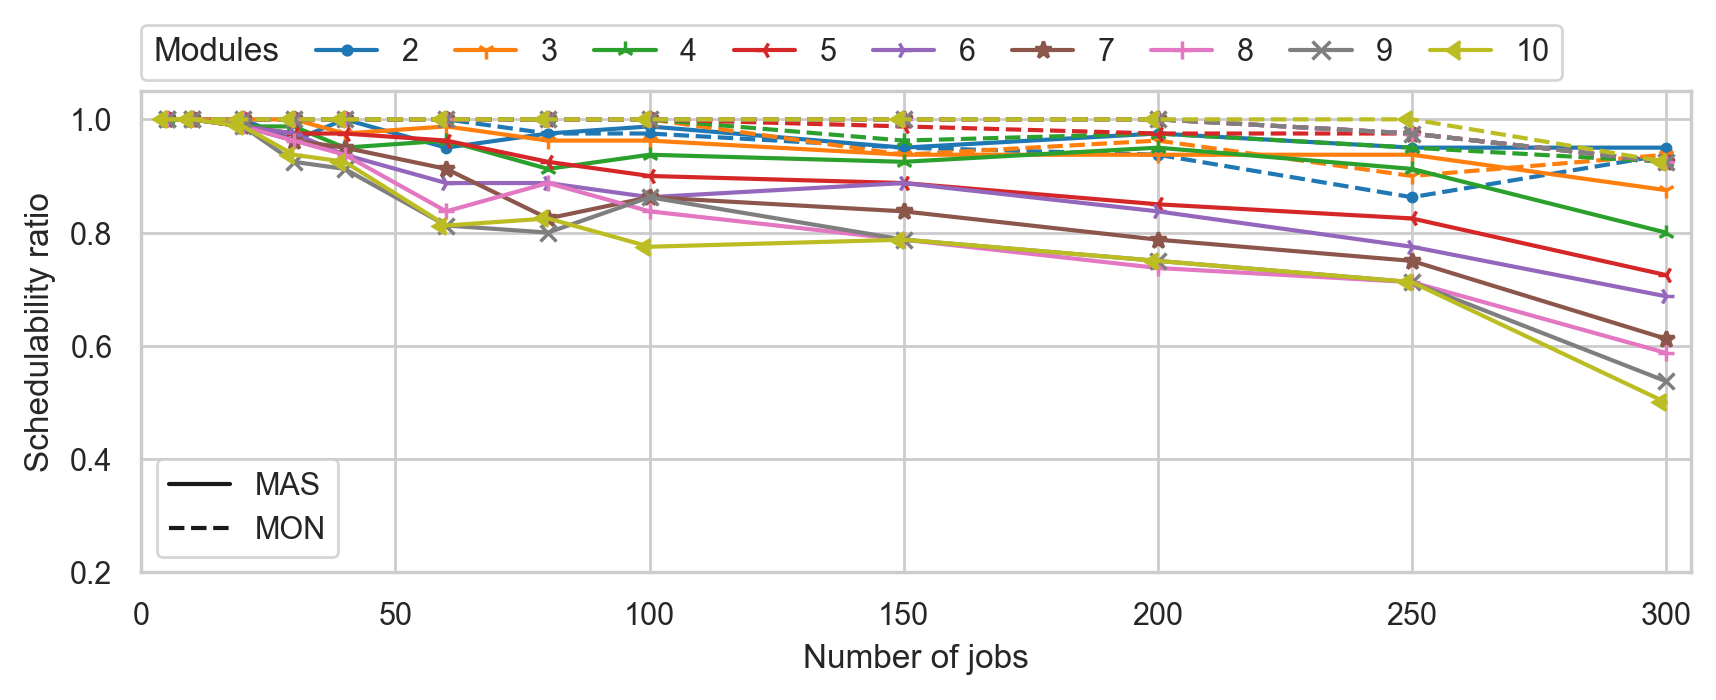

In [47]:
plt.figure(figsize=(8, 2.5), dpi=250)
for group, df in df_generic.groupby("modules"):
    group = cast(int, group)
    df_tmp = df.groupby(["modular_algorithm", "jobs"])["solved"].mean()
    plt.plot(
        df_tmp.loc["MAS-C"].index,
        df_tmp.loc["MAS-C"],
        color=number_colors[group],
        marker=number_markers[group],
    )
    plt.plot(
        df_tmp.loc["MON"].index,
        df_tmp["MON"],
        color=number_colors[group],
        marker=number_markers[group],
        linestyle="--",
    )
    
plt.ylim(.2, 1.05)
plt.xlim(0, 305)
# plt.xscale("log")
legend = plt.legend(
    [Line2D([], [], color="k"), Line2D([], [], color="k", linestyle="--")],
    ["MAS", "MON"],
)
l = plt.legend(
    [
        Line2D([0], [0], color=number_colors[i], marker=number_markers[i], markersize=5.0)
        for i in range(2, 11)
    ],
    [f"{i}" for i in range(2, 11)],
    loc='upper left',
    bbox_to_anchor=(-.01, 1.17),
    title="Modules",
    ncol=9,
    columnspacing=1.2,
    handletextpad=.8,
    handlelength=2
)

# From https://stackoverflow.com/a/53329898/4005637
c = l.get_children()[0]
title = c.get_children()[0]
hpack = c.get_children()[1]
c._children = [hpack]
hpack._children = [title] + hpack.get_children()

plt.gca().add_artist(legend)
plt.ylabel("Schedulability ratio")
plt.xlabel("Number of jobs")
plt.savefig(FIGS_DIR / "schedulability_ratio.pdf", bbox_inches="tight", pad_inches=0)
plt.show()


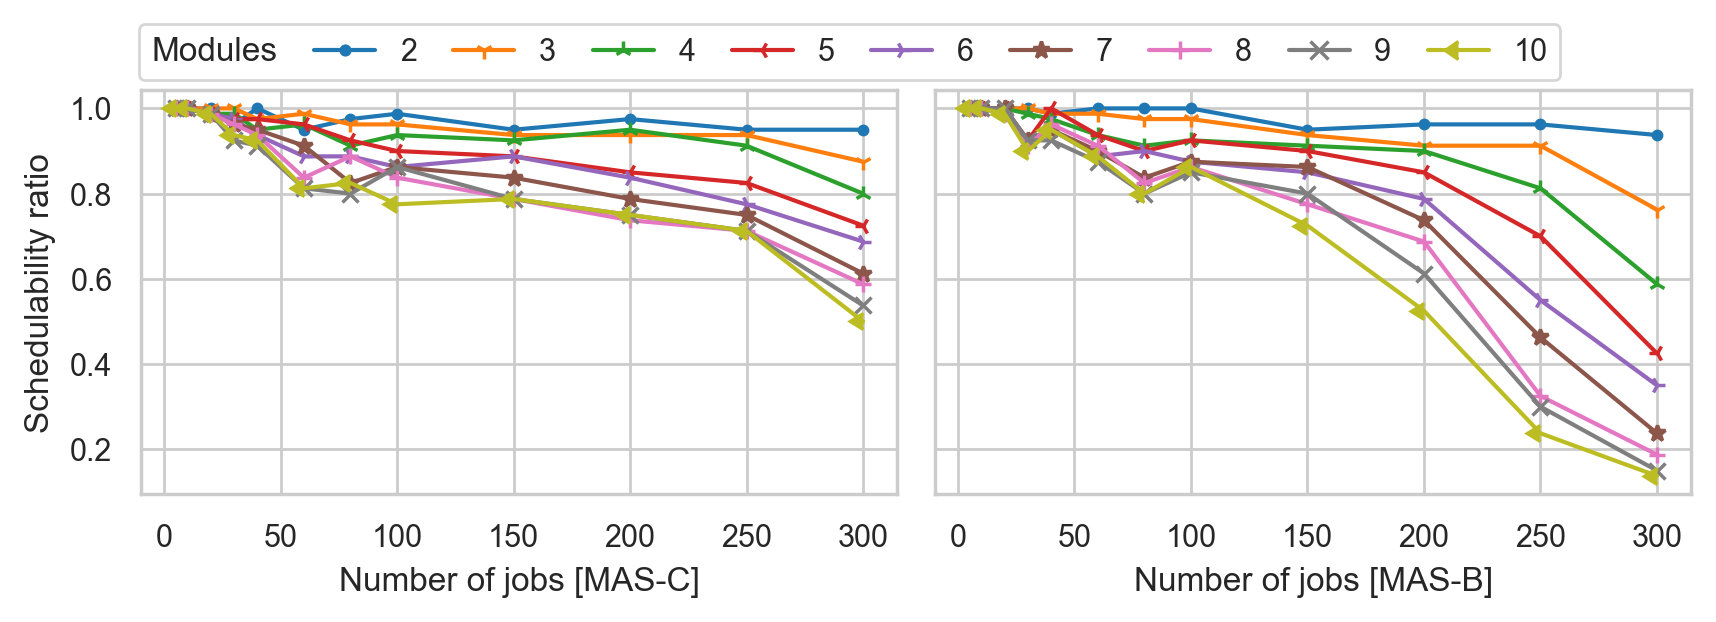

In [48]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 2.1), dpi=250, sharey=True)
plt.subplots_adjust(wspace=0.05)

for group, df in df_generic.groupby("modules"):
    group = cast(int, group)
    df_tmp = df.groupby(["modular_algorithm", "jobs"])["solved"].mean()
    ax1.plot(
        df_tmp.loc["MAS-C"].index,
        df_tmp.loc["MAS-C"],
        color=number_colors[group],
        marker=number_markers[group],
    )
    ax2.plot(
        df_tmp.loc["MAS-B"].index,
        df_tmp["MAS-B"],
        color=number_colors[group],
        marker=number_markers[group],
        # linestyle="--",
    )
    
l = ax1.legend(
    [
        Line2D([0], [0], color=number_colors[i], marker=number_markers[i], markersize=5.0)
        for i in range(2, 11)
    ],
    [f"{i}" for i in range(2, 11)],
    loc='upper left',
    bbox_to_anchor=(-.023, 1.2),
    title="Modules",
    ncol=9,
    columnspacing=1.2,
    handletextpad=.8,
    handlelength=2
)

# From https://stackoverflow.com/a/53329898/4005637
c = l.get_children()[0]
title = c.get_children()[0]
hpack = c.get_children()[1]
c._children = [hpack]
hpack._children = [title] + hpack.get_children()

ax1.set_ylabel("Schedulability ratio")
ax1.set_xlabel("Number of jobs [MAS-C]")
ax2.set_xlabel("Number of jobs [MAS-B]")
plt.savefig(FIGS_DIR / "schedulability_ratio_by_jobs_modules.pdf", bbox_inches="tight", pad_inches=0)
plt.show()


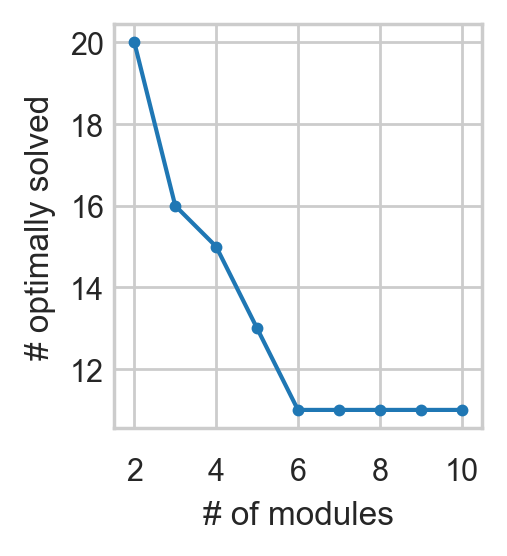

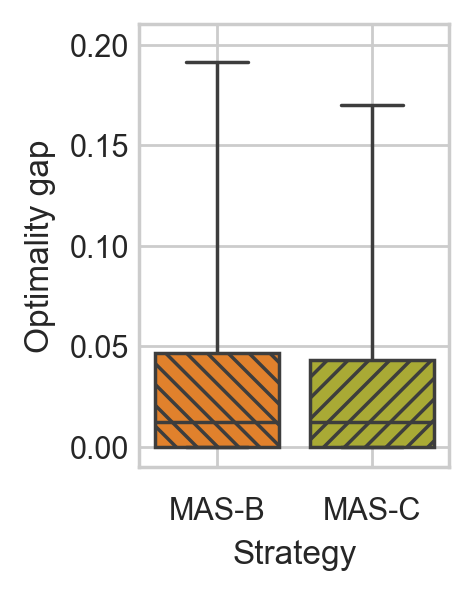

count      mean       std       min       25%  \
modular_algorithm time_limit                                                   
MAS-B             600          949.0  1.463653  0.440544  0.995121  1.086101   
                  3600        1026.0  1.468301  0.431258  0.995121  1.105891   
MAS-C             600         1024.0  1.377604  0.341606  0.996290  1.089927   
                  3600        1027.0  1.377495  0.341113  0.996290  1.090738   

                                   50%       75%       max  
modular_algorithm time_limit                                
MAS-B             600         1.331923  1.723886  2.614528  
                  3600        1.350645  1.698643  2.614528  
MAS-C             600         1.284577  1.572683  2.266193  
                  3600        1.285906  1.570176  2.266193

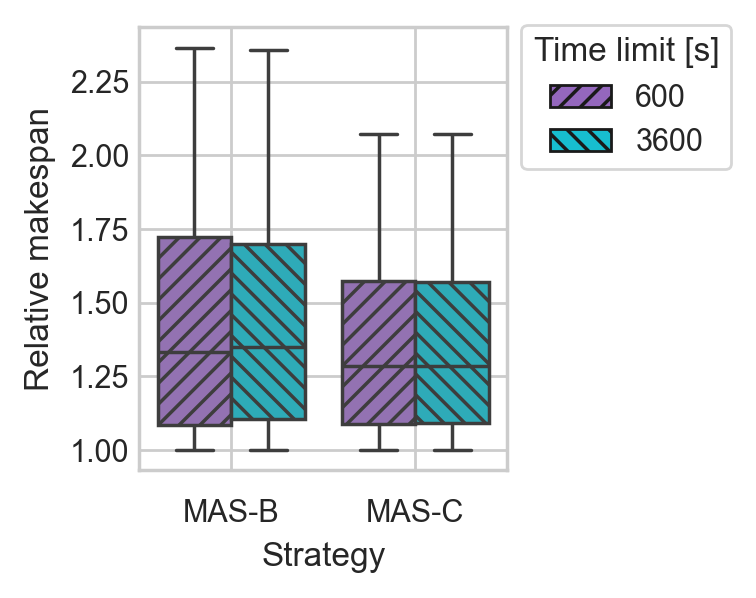

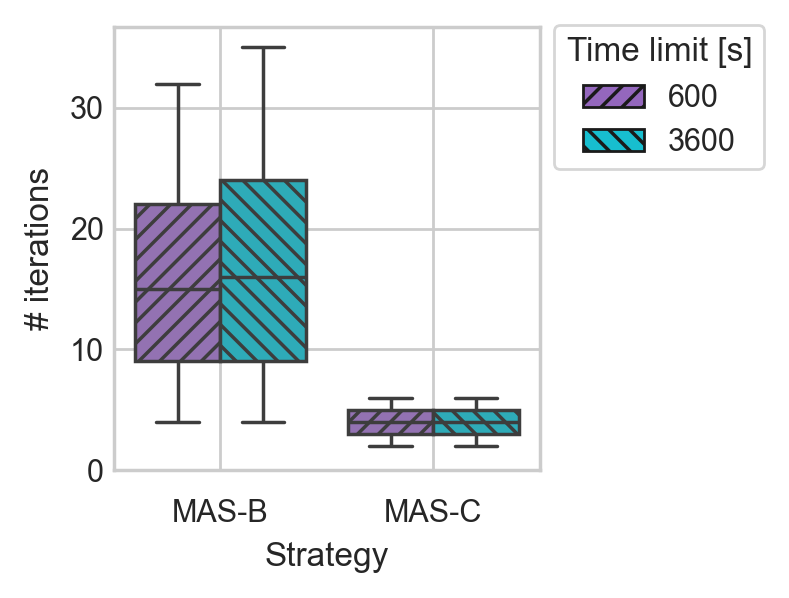

solved
modular_algorithm time_limit          
MAS-B             600         0.882407
                  3600        0.953704
MAS-C             600         0.951852
                  3600        0.954630

In [52]:
df_optimal = df_computational.query("modular_algorithm == 'MON' & optimal")[
    ["group", "original_path", "file_id", "makespan"]
].copy()
df_optimal["have_optimal"] = True

df_optimal = df_computational.merge(
    df_optimal, on=["group", "original_path", "file_id"], how="left", suffixes=(None, "_optimal")
).query("have_optimal == True & algorithm != 'simple'")

df_optimal["optimality_gap"] = (
    df_optimal["makespan"] - df_optimal["makespan_optimal"]
) / np.maximum(1e-10, df_optimal["makespan"])

df_optimal.loc[np.isclose(df_optimal["makespan"], df_optimal["makespan_optimal"]), "optimal"] = True

df_o = df_optimal.groupby(["modular_algorithm", "time_limit"])["optimal"].agg(["mean", "sum"])
df_o["mean"] *= 100
df_o = df_o.rename(columns={"mean": "%"})
display(df_o.style.format("{:.1f}", ["%"]))

display()


# Draw a linear plot of the number of optimal solutions found by MON depending on the
# number of jobs and modules
plt.figure(figsize=(1.9, 2.1), dpi=250)

df_selected = df_optimal.query("modular_algorithm == 'MON'")
df_tmp = df_selected.value_counts("modules")
sns.set_theme(context="paper", style="whitegrid")
plt.plot(
    df_tmp.index,
    df_tmp,
    color="tab:blue",
    marker=".",
)

# plt.ylim(0, 11)

plt.xlim(1.5, 10.5)
plt.xticks([2, 4, 6, 8, 10])
plt.tick_params(axis="y", pad=-2)

plt.ylabel("# optimally solved")
plt.xlabel("# of modules")
plt.savefig(FIGS_DIR / "computational_mon_optimal.pdf", bbox_inches="tight", pad_inches=0)


# Draw box plot comparing the optimality gap
plt.figure(figsize=(1.6, 2.3), dpi=250)
sns.set_theme(context="paper", style="whitegrid")

df_selected = df_optimal.query(
    "modular_algorithm != 'MON' & time_limit==3600"
)
g = sns.boxplot(
    data=df_selected,
    x="modular_algorithm",
    y="optimality_gap",
    hue="modular_algorithm",
    hue_order=["MAS-B", "MAS-C"],
    palette=colors,
    whis=(5, 95),
    showfliers=False,
)

hatches_lst = [hatches["MAS-B"], hatches["MAS-C"]]
for patch, hatch in zip(g.patches, hatches_lst):
    patch.set_hatch(hatch)

plt.ylim(-0.01, .21)
plt.ylabel("Optimality gap")
plt.xlabel("Strategy")
plt.tick_params(axis="y", pad=-2)
plt.grid(axis="x")
plt.savefig(FIGS_DIR / "computational_optimality_gap.pdf", bbox_inches="tight", pad_inches=0)
plt.show()


# Draw the relative makespan using MAS with 3600 seconds as a reference

df_compared = plot.baseline_compare(df_computational, "MON", "makespan")
df_compared = df_compared.query("algorithm != 'simple'")
display(df_compared.groupby(["modular_algorithm", "time_limit"])["makespan"].describe())

plt.figure(figsize=(1.9, 2.3), dpi=250)
sns.set_theme(context="paper", style="whitegrid")

g = sns.boxplot(
    data=df_compared,
    x="modular_algorithm",
    y="makespan",
    hue="time_limit",
    hue_order=[600, 3600],
    palette=colors,
    legend=False,
    whis=(5, 95),
    showfliers=False,
)

hatches_lst = [hatches[600]] * 2 + [hatches[3600]] * 2
for patch, hatch in zip(g.patches, hatches_lst):
    patch.set_hatch(hatch)
    
from matplotlib.patches import Patch
plt.legend(
    handles=[
        Patch(facecolor=colors[600], edgecolor="k", hatch=hatches[600], label="600"),
        Patch(facecolor=colors[3600], edgecolor="k", hatch=hatches[3600], label="3600"),
    ],
    loc="upper right",
    bbox_to_anchor=(1.65, 1.04),
    title="Time limit [s]"
)
    
plt.ylabel("Relative makespan")
plt.xlabel("Strategy")
plt.tick_params(axis="y", pad=-2)
plt.grid(axis="x")
plt.savefig(FIGS_DIR / "computational_makespan.pdf", bbox_inches="tight", pad_inches=0)
plt.show()



# Plot boxplot on the number of iterations when comparing the algorithms and the time limits

plt.figure(figsize=(2.2, 2.3), dpi=250)
sns.set_theme(context="paper", style="whitegrid")

df_selected = df_computational.query("modular_algorithm != 'MON' & algorithm != 'simple'")
g = sns.boxplot(
    data=df_selected,
    x="modular_algorithm",
    y="iterations",
    hue="time_limit",
    hue_order=[600, 3600],
    palette=colors,
    legend=False,
    whis=(5, 95),
    showfliers=False,
)

hatches_lst = [hatches[600]] * 2 + [hatches[3600]] * 2
for patch, hatch in zip(g.patches, hatches_lst):
    patch.set_hatch(hatch)
    
from matplotlib.patches import Patch
plt.legend(
    handles=[
        Patch(facecolor=colors[600], edgecolor="k", hatch=hatches[600], label="600"),
        Patch(facecolor=colors[3600], edgecolor="k", hatch=hatches[3600], label="3600"),
    ],
    loc="upper right",
    bbox_to_anchor=(1.562, 1.04),
    title="Time limit [s]"
)

plt.ylim(0, None)
plt.ylabel("# iterations")
plt.xlabel("Strategy")
plt.tick_params(axis="y", pad=-2)
plt.grid(axis="x")
plt.savefig(FIGS_DIR / "computational_iterations.pdf", bbox_inches="tight", pad_inches=0)
plt.show()

display(df_selected.groupby(["modular_algorithm", "time_limit"])["solved"].mean().to_frame())